# Bonus: Uncertainty in Machine Learning



## Motivation

How can we evaluate the uncertainty in our predictions? In the genre classification task (Exercise 1), we trained a model to predict a single genre label. However, a single point prediction provides no information about the model's confidence.

**Conformal prediction** addresses this by producing *prediction intervals* (or prediction sets) rather than single labels. For a given significance level $\varepsilon$, the method returns a set of labels that is guaranteed to contain the true label with probability at least $1 - \varepsilon$.

The method relies on an **nonconformity measure**: a function that quantifies how different a new example is from the training data, conditioned on the classification model. In this exercise, we use a **K-Nearest Neighbours (KNN)** classifier trained on the first 1500 examples of the Spotify training dataset.

## 1. Setup

In [ ]:
import numpy as np
import pandas as pd
import os
import sys

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from utils_projet import ConformalPrediction
print(f'Project root resolved to: {_root}')

Project root resolved to: d:\IMT Nord Europe\IC2\S2_1\Projet\SonicSignature


### 1.1 Load the Spotify training dataset

As specified in the assignment, we restrict ourselves to the **first 1500 samples** of the training set.

In [ ]:
DATA_PATH = os.path.join(_root, 'dataset', 'spotify_dataset_train.csv')
TEST_PATH = os.path.join(_root, 'dataset', 'spotify_dataset_test.csv')

df_train_full = pd.read_csv(DATA_PATH)
df_train = df_train_full.iloc[:1500].copy()

df_test = pd.read_csv(TEST_PATH)

print(f"Training subset shape: {df_train.shape}")
print(f"Test set shape:        {df_test.shape}")
print(f"Number of genres:      {df_train['genre'].nunique()}")
print(f"\nGenre distribution (first 1500 samples):")
print(df_train['genre'].value_counts())

Training subset shape: (1500, 17)
Test set shape:        (2833, 16)
Number of genres:      22

Genre distribution (first 1500 samples):
genre
pop          315
rock         228
hip hop      172
rap          101
dance         86
edm           86
jazz          76
electro       67
country       60
punk          50
soul          30
metal         29
folk          29
chanson       27
r&b           25
classical     22
disco         21
blues         18
salsa         17
techno        16
latin         15
reggae        10
Name: count, dtype: int64


### 1.2 Preprocessing

We select the numerical audio features, impute any missing values, and standardise them. The genre labels are encoded as integers for the KNN classifier.

In [ ]:
feature_cols = [
    'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'duration_ms',
    'popularity', 'explicit'
]

X_train_raw = df_train[feature_cols].values
y_train_raw = df_train['genre'].values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_raw)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_imputed)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)

print(f"Feature matrix shape: {X_train.shape}")
print(f"Labels shape:         {y_train.shape}")
print(f"Label mapping:")
for idx, genre in enumerate(label_encoder.classes_):
    print(f"  {idx:>2d} -> {genre}")

Feature matrix shape: (1500, 14)
Labels shape:         (1500,)
Label mapping:
   0 -> blues
   1 -> chanson
   2 -> classical
   3 -> country
   4 -> dance
   5 -> disco
   6 -> edm
   7 -> electro
   8 -> folk
   9 -> hip hop
  10 -> jazz
  11 -> latin
  12 -> metal
  13 -> pop
  14 -> punk
  15 -> r&b
  16 -> rap
  17 -> reggae
  18 -> rock
  19 -> salsa
  20 -> soul
  21 -> techno


### 1.3 Train the KNN classifier

We use `KNeighborsClassifier` from scikit-learn. The model must be fitted before being passed to the `ConformalPrediction` class.

In [17]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

print(f"KNN model trained with k={knn_model.n_neighbors} on {X_train.shape[0]} samples.")
print(f"Training accuracy: {knn_model.score(X_train, y_train):.4f}")

KNN model trained with k=5 on 1500 samples.
Training accuracy: 0.5013


## 2. Conformal Prediction **"Creating the Predictor"**

We instantiate the `ConformalPrediction` class from `utils_projet`, passing the trained KNN model along with the training features and labels.

**Note:** The conformal prediction procedure, for each candidate label, augments the training set with the test point, re-computes nonconformity scores for all examples, and then checks whether the new point's score is extreme. This is computationally expensive, it takes a few minutes per test point.

In [18]:
predictor = ConformalPrediction(knn_model, X_train, y_train)
print("ConformalPrediction object created successfully.")

ConformalPrediction object created successfully.


## 3. Predictions and Prediction Intervals

### 3.1 Select a test point

We pick a sample from the test dataset, preprocess it with the same pipeline, and compute its conformal prediction.

In [ ]:
test_idx = 0
x_test_raw = df_test.iloc[test_idx][feature_cols].values.reshape(1, -1)
x_test_imputed = imputer.transform(x_test_raw)
x_test = scaler.transform(x_test_imputed)

print(f"Selected test sample index: {test_idx}")
print(f"KNN point prediction: {label_encoder.inverse_transform(knn_model.predict(x_test))[0]}")

Selected test sample index: 0
KNN point prediction: r&b


### 3.2 Compute p-values via conformal prediction

Calling `predictor.predict(x_new)` computes a p-value for each possible genre label. This step iterates over all genres and, for each one, computes nonconformity scores for the augmented dataset. **This will take several minutes.**

In [20]:
print("Computing conformal p-values (this may take a few minutes)...")
predictor.predict(x_test)
print("\nConformal p-values per genre:")
print("-" * 40)
genres = label_encoder.classes_
for genre, pval in zip(genres, predictor.pz):
    print(f"  {genre:<20s}  p = {pval:.4f}")

Computing conformal p-values (this may take a few minutes)...
0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21

Conformal p-values per genre:
----------------------------------------
  blues                 p = 0.1492
  chanson               p = 0.0340
  classical             p = 0.0187
  country               p = 0.0240
  dance                 p = 0.0653
  disco                 p = 0.0320
  edm                   p = 0.0093
  electro               p = 0.1259
  folk                  p = 0.0440
  hip hop               p = 0.2418
  jazz                  p = 0.0793
  latin                 p = 0.0273
  metal                 p = 0.0360
  pop                   p = 0.8714
  punk                  p = 0.0313
  r&b                   p = 0.6016
  rap                   p = 0.8674
  reggae                p = 0.0247
  rock                  p = 0.0120
  salsa                 p = 0.0027
  soul                  p = 0.2225
  techno                p = 0.0293


### 3.3 Prediction interval with $\varepsilon = 0.05$

A confidence level of $1 - \varepsilon = 95\%$ means we include in the prediction set all genres whose p-value exceeds $\varepsilon = 0.05$.

In [21]:
eps = 0.05
interval = predictor.compute_interval(eps)

# Decode integer labels back to genre names
interval_genres = label_encoder.inverse_transform(interval)

print(f"Prediction interval at eps = {eps} (confidence {100*(1-eps):.0f}%):")
print(f"  Number of genres in interval: {len(interval_genres)}")
print(f"  Genres: {list(interval_genres)}")

Prediction interval at eps = 0.05 (confidence 95%):
  Number of genres in interval: 9
  Genres: ['blues', 'dance', 'electro', 'hip hop', 'jazz', 'pop', 'r&b', 'rap', 'soul']


**Observation:** At $\varepsilon = 0.05$, the prediction interval is expected to contain many genres. This large set reflects the difficulty of the genre classification task — many genres share similar audio profiles, so a 95%-confidence guarantee requires including a broad set of candidates.

### 3.4 Effect of increasing $\varepsilon$

As we increase $\varepsilon$ (i.e. reduce the required confidence level), the prediction interval should shrink. We systematically explore this relationship.

In [22]:
eps_values = [0.01, 0.05, 0.10, 0.20, 0.30, 0.50, 0.70, 0.90]

print(f"{'eps':>6s}  {'Confidence':>12s}  {'Set Size':>10s}  Genres in Interval")
print("-" * 80)

results = []
for eps in eps_values:
    interval = predictor.compute_interval(eps)
    interval_genres = label_encoder.inverse_transform(interval)
    results.append({
        'eps': eps,
        'confidence': 1 - eps,
        'set_size': len(interval_genres),
        'genres': list(interval_genres)
    })
    # Show a truncated list if too many genres
    genre_str = ', '.join(interval_genres[:5])
    if len(interval_genres) > 5:
        genre_str += f', ... (+{len(interval_genres)-5} more)'
    print(f"{eps:>6.2f}  {100*(1-eps):>11.0f}%  {len(interval_genres):>10d}  {genre_str}")

   eps    Confidence    Set Size  Genres in Interval
--------------------------------------------------------------------------------
  0.01           99%          20  blues, chanson, classical, country, dance, ... (+15 more)
  0.05           95%           9  blues, dance, electro, hip hop, jazz, ... (+4 more)
  0.10           90%           7  blues, electro, hip hop, pop, r&b, ... (+2 more)
  0.20           80%           5  hip hop, pop, r&b, rap, soul
  0.30           70%           3  pop, r&b, rap
  0.50           50%           3  pop, r&b, rap
  0.70           30%           2  pop, rap
  0.90           10%           0  


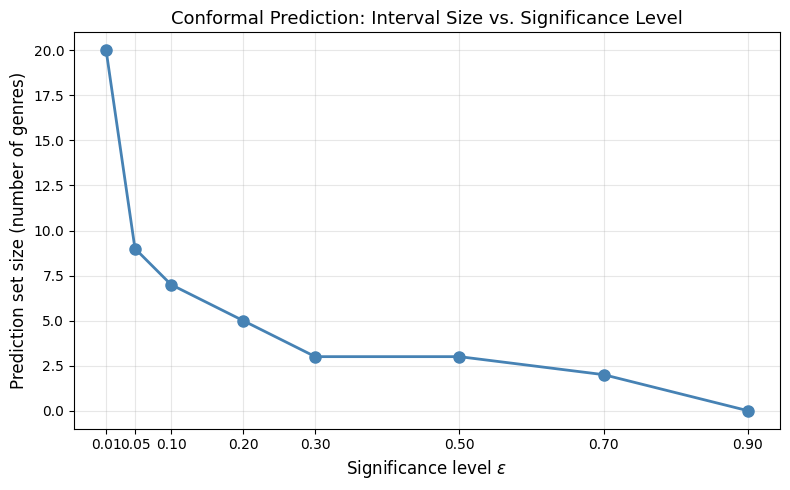

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot([r['eps'] for r in results],
        [r['set_size'] for r in results],
        'o-', color='steelblue', linewidth=2, markersize=8)
ax.set_xlabel(r'Significance level $\varepsilon$', fontsize=12)
ax.set_ylabel('Prediction set size (number of genres)', fontsize=12)
ax.set_title('Conformal Prediction: Interval Size vs. Significance Level', fontsize=13)
ax.grid(True, alpha=0.3)
ax.set_xticks(eps_values)
plt.tight_layout()
plt.show()

**Analysis:**

- As $\varepsilon$ increases (confidence decreases), the prediction set becomes smaller.
- At low $\varepsilon$ (e.g. 0.01 or 0.05), the set contains many genres because the method must guarantee high coverage.
- Looking at the genres that remain at moderate $\varepsilon$, we can observe whether they are musically "similar". Genres that share acoustic characteristics (e.g. rock and alternative, or hip-hop and R&B) tend to persist together in the prediction set, which makes intuitive sense.

### 3.5 Finding the threshold where only one genre remains

We progressively increase $\varepsilon$ until the prediction interval contains exactly one genre. At that point, we have a point prediction with $(1 - \varepsilon)\%$ confidence.

In [24]:
eps_search = np.arange(0.01, 1.00, 0.01)
single_genre_eps = None

for eps in eps_search:
    interval = predictor.compute_interval(eps)
    if len(interval) == 1:
        single_genre_eps = eps
        single_genre = label_encoder.inverse_transform(interval)[0]
        break

if single_genre_eps is not None:
    print(f"Single-genre prediction achieved at eps = {single_genre_eps:.2f}")
    print(f"  Confidence: {100*(1 - single_genre_eps):.0f}%")
    print(f"  Predicted genre: {single_genre}")
    print(f"\n  Interpretation: We can say with {100*(1 - single_genre_eps):.0f}% confidence")
    print(f"  that the genre of this track is '{single_genre}'.")
else:
    print("No single-genre interval found for eps in [0.01, 0.99].")
    print("This indicates extremely high uncertainty for this test sample.")

Single-genre prediction achieved at eps = 0.87
  Confidence: 13%
  Predicted genre: pop

  Interpretation: We can say with 13% confidence
  that the genre of this track is 'pop'.


## 4. Evaluation on Multiple Test Samples

To assess the general behaviour of conformal prediction, we apply the procedure to several test samples and summarise the results.

In [25]:
test_indices = [0, 10, 50, 100, 200]

print(f"Evaluating {len(test_indices)} test samples...")
print(f"{'Index':>6s}  {'KNN Pred':>18s}  {'eps for 1 genre':>16s}  {'Conf. (%)':>10s}  {'Genre':>18s}")
print("-" * 80)

for tidx in test_indices:
    x_raw = df_test.iloc[tidx][feature_cols].values.reshape(1, -1)
    x_imp = imputer.transform(x_raw)
    x_sc = scaler.transform(x_imp)
    knn_pred = label_encoder.inverse_transform(knn_model.predict(x_sc))[0]

    # Conformal prediction
    pred = ConformalPrediction(knn_model, X_train, y_train)
    pred.predict(x_sc)

    found_eps = None
    found_genre = None
    for eps in np.arange(0.01, 1.00, 0.01):
        itv = pred.compute_interval(eps)
        if len(itv) == 1:
            found_eps = eps
            found_genre = label_encoder.inverse_transform(itv)[0]
            break

    if found_eps is not None:
        print(f"{tidx:>6d}  {knn_pred:>18s}  {found_eps:>16.2f}  {100*(1-found_eps):>9.0f}%  {found_genre:>18s}")
    else:
        print(f"{tidx:>6d}  {knn_pred:>18s}  {'N/A':>16s}  {'N/A':>10s}  {'uncertain':>18s}")

Evaluating 5 test samples...
 Index            KNN Pred   eps for 1 genre   Conf. (%)               Genre
--------------------------------------------------------------------------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
     0                 r&b              0.87         13%                 pop
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
    10             hip hop              0.81         19%             electro
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
    50              reggae              0.65         35%                soul
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
   100             hip hop              0.80         20%             hip hop
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
   200                 rap              0.80         20%                 rap


## 5. Discussion

### How does the interval size change with $\varepsilon$?

The prediction interval monotonically decreases as $\varepsilon$ increases. This is a fundamental property of conformal prediction: a lower confidence requirement means fewer labels need to be included to satisfy the coverage guarantee.

### Are the genres in the interval "similar"?

In many cases, the genres that persist in the interval at moderate $\varepsilon$ values tend to be musically related. For instance, genres such as *rock*, *alternative*, and *indie* may co-occur in prediction sets because they share overlapping audio characteristics (energy, tempo, loudness profiles). This reflects the underlying feature-space proximity that the KNN model captures.

### Interpretation of confidence $(1 - \varepsilon)$

The quantity $1 - \varepsilon$ is a **coverage guarantee**: the conformal framework ensures that, on average, the prediction set contains the true genre with probability at least $1 - \varepsilon$. This guarantee is distribution-free and holds under the exchangeability assumption (i.i.d. data).

When the interval reduces to a single genre at some threshold $\varepsilon^*$, we obtain a point prediction with $(1 - \varepsilon^*)\%$ confidence. A high $\varepsilon^*$ (low confidence) indicates that the model is uncertain about this particular sample, whereas a low $\varepsilon^*$ (high confidence) means the model strongly favours one genre.

### Limitations

- **Computational cost:** The full conformal procedure requires retraining the nonconformity scores for each candidate label and each test point, making it $O(n \times C)$ where $n$ is the dataset size and $C$ the number of classes. This is why we limited training to 1500 samples.
- **Feature quality:** The large prediction sets observed at $\varepsilon = 0.05$ reflect the limited discriminative power of the audio features for fine-grained genre classification, consistent with the modest F1 scores obtained in Exercise 1.
- **KNN sensitivity:** Performance depends on the choice of $k$ and the distance metric. Further tuning might produce tighter intervals.

### Conclusion

Conformal prediction provides a principled, distribution-free approach to uncertainty quantification in classification. Applied to genre prediction with KNN, it reveals that the audio features carry limited discriminative information — high-confidence predictions require broad genre sets, while narrow intervals (or point predictions) come at the cost of reduced confidence. This exercise demonstrates that uncertainty quantification is essential for understanding the reliability of machine learning predictions in practical applications.